# Comparing tuned MC and ML models on augmented Test sets

### TODO

Experiments

- Gaussian noise - random intensities
- Rotation - random angles between -45 and +45, increments of 5
- Brightness - random gamma values

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import math
from scipy import ndimage

import json

import torch
import torch.nn.functional as F

import time
from tqdm import tqdm

from model_utils import ModelWrapper, myDataLoader
from model_utils.braille_utils import num_to_bin_string, bin_to_num, num_to_bin, ml_to_mc, mc_to_ml, bin_to_string, string_to_bin
from model_utils.metrics import sigmoid_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, bitwise_F1,\
    macro_metrics, macro_recall, macro_precision, macro_F1, hamming_distances, mean_hamming_distance, mean_error_distance
from model_utils.augment import label_balance_resample, class_balance_resample, apply_augmentations
from model_utils.metrics import class_balance, label_correlations, class_frequency, between_label_imbalance, mean_mutual_information


c:\Users\User\OneDrive\Uni\Braille Research\Braille ML\venv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
sns.set_theme(style="darkgrid", font_scale=1.1)
PAL = sns.color_palette()

DATASETS = os.path.join('..', '..', 'Datasets', 'numpy_datasets')
MODEL_PATH = os.path.join('..', 'models')
PLOTS = os.path.join('..', 'plots')
EVAL = os.path.join('..', 'evals')
ML_LOGS = os.path.join('..', 'opt_logs', 'ml_tuning')
MC_LOGS = os.path.join('..', 'opt_logs', 'mc_tuning')

PAL

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [4]:
BLUE = "#1f77b4"
GREY = "#8F8F8F"
ORANGE = "#ffa35c"
RED = "#e50c3f"
YELLOW = "#f1c232"
DARK = "#0c343d"
LIGHT = "#efeae6"

## Data Processing

In [6]:
angelina = os.path.join(DATASETS, "angelina.npz")
dsbi = os.path.join(DATASETS, "dsbi.npz")

data = np.load(angelina)
ood = np.load(dsbi)
print(data['train_x'].shape)
print(ood['test_x'].shape)

(69267, 40, 30, 3)
(45627, 40, 30, 3)


In [7]:
train_X = data["train_x"] / 255.
train_Y = data["train_y"]

val_X = data["val_x"] / 255.
val_Y = data["val_y"]

test_X = data["test_x"] / 255.
test_Y = data["test_y"]

N, p = train_Y.shape

In [8]:
train_Y_cat = ml_to_mc(train_Y)
val_Y_cat = ml_to_mc(val_Y)
test_Y_cat = ml_to_mc(test_Y)

test_Y_str = bin_to_string(test_Y)

C = train_Y_cat.shape[1]

In [9]:
ood_X = ood['test_x'] / 255.
ood_Y = ood['test_y']
ood_Y_cat = ml_to_mc(ood_Y)

In [10]:
del data, ood

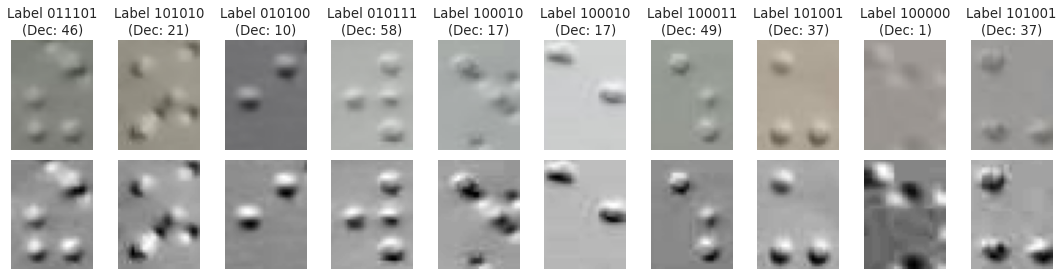

In [12]:
plt.figure(figsize=(15,4))
np.random.seed(101010)
subset = np.random.choice(np.arange(0, N), 10)

for i in range(10):
    sample = (train_X[subset[i]]).astype(np.float32)
    plt.subplot(2,10, i+1)
    plt.axis("off")
    lbl = ''.join(train_Y[subset[i]].astype(str))
    num_lbl = np.argmax(train_Y_cat[subset[i]])
    plt.imshow(sample)
    plt.title("Label {}\n(Dec: {})".format(lbl, num_lbl))
    
    gray = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    plt.subplot(2,10, i+11)
    plt.axis("off")
    plt.gray()
    plt.imshow(gray)
plt.tight_layout()

In [34]:
ml_to_mc(test_Y)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Model Loading

In [10]:
param_space = {
    'lr': (0.0001, 0.02),
    'beta_1': (0.85, 0.95),
    'beta_2': (0.99, 0.9999),
    'l2': (0.0001, 0.03),
    'filters': (8, 64),
    'kernel_sz': (2,5),
    'dense_sz': (25, 150),
    'activs': (0, 2),
    'padding': (0, 1),
    'grey': (0, 1),
    'sqr': (0, 1)
}

param_names = [
    'Learning Rate', 'Beta1', 'Beta2', 'L2 Penalty',
    'Num Filters', 'Kernel Size', 'Dense Layer Size',
    'Activation function', 'Padding', 
    'Grey scaling', 'Square Input'
]

activations = {
    0: F.relu,
    1: F.tanh,
    2: F.leaky_relu
}

In [11]:
DEV = 'cpu'

In [12]:
base_ml_model = ModelWrapper(dev=DEV)
base_ml_model.load(os.path.join(MODEL_PATH, 'base_ml_model_v2'))

base_mc_model = ModelWrapper(dev=DEV)
base_mc_model.load(os.path.join(MODEL_PATH, 'base_mc_model_v2'))

In [13]:
lb_ml_model = ModelWrapper(dev=DEV)
lb_ml_model.load(os.path.join(MODEL_PATH, 'lb_ml_model'))

lb_mc_model = ModelWrapper(dev=DEV)
lb_mc_model.load(os.path.join(MODEL_PATH, 'lb_mc_model'))

In [14]:
cb_ml_model = ModelWrapper(dev=DEV)
cb_ml_model.load(os.path.join(MODEL_PATH, 'cb_ml_model'))

cb_mc_model = ModelWrapper(dev=DEV)
cb_mc_model.load(os.path.join(MODEL_PATH, 'cb_mc_model'))

In [15]:
ab_ml_model = ModelWrapper(dev=DEV)
ab_ml_model.load(os.path.join(MODEL_PATH, 'ab_ml_model'))

ab_mc_model = ModelWrapper(dev=DEV)
ab_mc_model.load(os.path.join(MODEL_PATH, 'ab_mc_model'))

In [16]:
NUM_CLASSES = 64
NUM_LABELS = 6

## Standard Names

In [17]:
# names
BASE = 'No Resampling'
CB = 'Class Resampled'
LB = 'Label Resampled'
AB = 'Adaptive Resampled'
MC = 'Multiclass'
ML = 'Multilabel'

ID = 'In-distribution'
DSBI = 'DSBI'
B37 = 'Braille37'
BCD = 'BCD'
ABC = 'ABC'
BRIGHT = 'Brightness Augmented'
NOISE = 'Noise Augmented'
ROT = 'Rotation Augmented'

resamplings_abbr = ['Base', 'CB', 'LB', 'AB']
resamplings = [BASE, CB, LB, AB]
model_names_abbr = ['MC', 'ML']
model_names = [MC, ML]
evaluations = [
    ID,
    DSBI,
    B37,
    BCD,
    ABC,
    BRIGHT,
    NOISE,
    ROT
]


In [18]:
MODEL_COL = 'Model'
TRAIN_COL = 'Resampling Scenario'
EVAL_COL = 'Evaluation'

metrics = ['Class Accuracy', 'Label Accuracy', 'Mean Error',
                   'Class Recall', 'Class Precision', 'Class F1',
                   'Label Recall', 'Label Precision', 'Label F1']

article_metrics = [f"1 - {met}" if 'Error' not in met else met for met in metrics]

## Experimental Augmentations

In [5]:
B = 16
R = 17
N = 17
F = 16
C = 2

gamma_space = np.linspace(1.0, 1.3, B)
angle_space = np.linspace(-25, 25, R)
noise_space = np.linspace(0, 0.1, N)
blur_space = np.linspace(0, 3.0, F)
control_space = np.linspace(0, 1, C)

gamma_space, angle_space, noise_space, blur_space

(array([1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 ,
        1.22, 1.24, 1.26, 1.28, 1.3 ]),
 array([-25.   , -21.875, -18.75 , -15.625, -12.5  ,  -9.375,  -6.25 ,
         -3.125,   0.   ,   3.125,   6.25 ,   9.375,  12.5  ,  15.625,
         18.75 ,  21.875,  25.   ]),
 array([0.     , 0.00625, 0.0125 , 0.01875, 0.025  , 0.03125, 0.0375 ,
        0.04375, 0.05   , 0.05625, 0.0625 , 0.06875, 0.075  , 0.08125,
        0.0875 , 0.09375, 0.1    ]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. ]))

In [23]:

test_N = test_Y.shape[0]
print(f"Test set size {test_N}. Average samples per band for\n\tControl Experiment: {round(test_N / C, 3)}\n\tBrightness Experiment: {round(test_N / B, 3)}\n\tRotation Experiment: {round(test_N / R, 3)}\n\tNoise Experiment: {round(test_N / N, 3)}\n\tBlur Experiment: {round(test_N / F, 3)}")

Test set size 12016. Average samples per band for
	Control Experiment: 187.75
	Brightness Experiment: 751.0
	Rotation Experiment: 706.824
	Noise Experiment: 0.173
	Blur Experiment: 751.0


In [11]:
from scipy.ndimage.filters import gaussian_filter

C:\Users\User\AppData\Local\Temp\ipykernel_62888\2664825262.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [12]:
def set_control(image, control):
    return (image * 0) + control

def decrease_brightness(image, gamma):
    return (image ** gamma) * 255 / (255 ** gamma)

def rotate_image(image, angle):
    rotated = ndimage.rotate(image, angle, reshape=False, mode='nearest')
    return rotated
    
def add_noise(image, noise):
    noisy = image + np.random.normal(0, noise, image.shape)
    return np.clip(noisy, 0, 1)

def add_blur(image, blur):
    return gaussian_filter(image, sigma=blur)
    

In [13]:
def show_sample(sample, ax):
    # plt.figure(figsize=(3,3))
    sample = sample.astype(np.float32)
    ax.axis("off")
    ax.imshow(sample)

In [14]:
models = [base_mc_model, base_ml_model,
          cb_mc_model, cb_ml_model,
          lb_mc_model, lb_ml_model,
          ab_mc_model, ab_ml_model]
model_names = ['Base MC', 'Base ML',
               'CB MC', 'CB ML',
               'LB MC', 'LB ML',
               'AB MC', 'AB ML']

model_training = {
    'Base MC': BASE,
    'Base ML': BASE,
    'CB MC': CB,
    'CB ML': CB,
    'LB MC': LB,
    'LB ML': LB,
    'AB MC': AB,
    'AB ML': AB
}
model_type = {
    'Base MC': MC,
    'Base ML': ML,
    'CB MC': MC,
    'CB ML': ML,
    'LB MC': MC,
    'LB ML': ML,
    'AB MC': MC,
    'AB ML': ML
}

metric_ranges = {
    metric: (0,1) for metric in metrics 
}
metric_ranges['Mean Error'] = (1,6)
model_names

NameError: name 'base_mc_model' is not defined

In [24]:
def per_class_metric_suite(preds, trues):
    _, classes = preds.shape
    TPs, TNs, FPs, FNs = macro_metrics(preds, trues)
    
    # accuracy = []
    recall = []
    precision = []
    f1 = []
    for i in range(classes):
        # a = (TPs[i] + TNs[i]) / (TPs[i] + FPs[i] + TNs[i] + FNs[i])
        p = TPs[i] / (TPs[i] + FPs[i])
        r = TPs[i] / (TPs[i] + FNs[i])
        f = 2 * p * r / (p + r)
        
        # accuracy.append(a)
        precision.append(p)
        recall.append(r)
        f1.append(f)
    return {
        'Recall': np.nanmean(recall),
        'Precision': np.nanmean(precision),
        'F1': np.nanmean(f1)
        }

In [25]:
metrics

['Class Accuracy',
 'Label Accuracy',
 'Mean Error',
 'Class Recall',
 'Class Precision',
 'Class F1',
 'Label Recall',
 'Label Precision',
 'Label F1']

In [26]:
def unstack_grouped_df(grouped_df, name):
    return grouped_df.unstack().to_frame().reset_index().rename(columns={'level_0': 'model_name', 0: name})

def get_grouped_metrics(group):
    model_metrics = {
        'index': metrics
    }
    for model in group.columns:
        if model == 'true_label':
            continue
        y_true = string_to_bin(group['true_label'])
        y_pred = string_to_bin(group[model])

        y_true_mc = ml_to_mc(y_true)
        y_pred_mc = ml_to_mc(y_pred)
        
        per_label_mean = per_class_metric_suite(y_pred, y_true)
        per_class_mean = per_class_metric_suite(y_pred_mc, y_true_mc)
        
        results = [sigmoid_accuracy(y_pred, y_true), bitwise_accuracy(y_pred, y_true), mean_error_distance(y_pred, y_true)] + [
            per_class_mean[met] for met in per_class_mean.keys() if met != 'Accuracy'
        ] + [
            per_label_mean[met] for met in per_label_mean.keys() if met != 'Accuracy'
        ]
        model_metrics[model] = results
    return model_metrics


In [27]:
TRIALS = 15
pred_columns = ['true_label'] + model_names

def conduct_augmentation_trial(aug_func, aug_space, aug_name):
    aug_params = np.random.choice(aug_space, test_N, replace=True)

    test_X_aug = np.array([aug_func(test_X[i], aug_params[i]) for i in range(test_N)])
    ml_test_loader = myDataLoader(test_X_aug, test_Y, batch_sz=2048, dev=DEV)
    mc_test_loader = myDataLoader(test_X_aug, test_Y_cat, batch_sz=2048, dev=DEV)
    predictions = pd.DataFrame({aug_name: aug_params, 'true_label': test_Y_str})
    
    for i, (model, model_name) in enumerate(zip(models, model_names)):
        if i % 2 == 0:
            preds = model.predict(mc_test_loader, verbose=1)
            predictions[model_name] = bin_to_string(num_to_bin(preds))
        else:
            preds = model.predict(ml_test_loader, verbose=1)
            predictions[model_name] = bin_to_string(preds)

    overall_metrics = pd.DataFrame(get_grouped_metrics(predictions.drop(columns=aug_name)))
    overall_metrics = overall_metrics.set_index('index').T.reset_index().rename(columns={'index': 'model_name'})

    nested_grouped_metrics = predictions.groupby(aug_name)[pred_columns].apply(get_grouped_metrics)
    dfs = []
    for aug in nested_grouped_metrics.index:
        aug_df = pd.DataFrame(nested_grouped_metrics[aug]).set_index('index').T.reset_index().rename(columns={'index': 'model_name'})
        aug_df[aug_name] = aug
        dfs.append(aug_df)
    grouped_metrics = pd.concat(dfs)

    return grouped_metrics, overall_metrics

### Sample Augmentations

In [20]:
(test_X[s] - add_blur(test_X[s], 0.0)).sum()

0.0

0.8784313725490196
0.7358016848991952
1.0
1.0


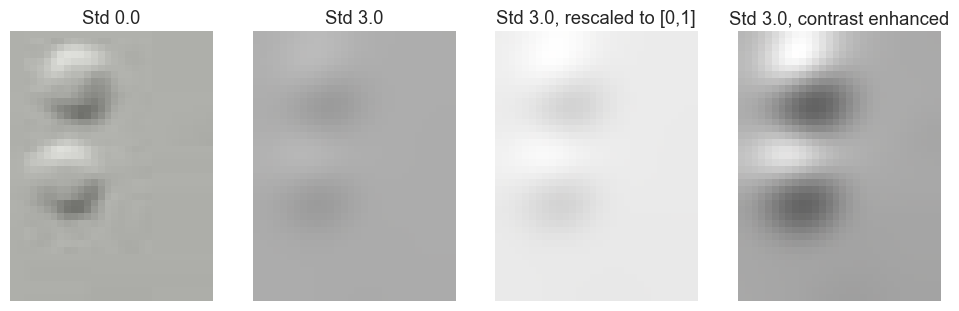

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))
s = 10#np.random.randint(low=0, high=test_N)
std = 3.0

show_sample(test_X[s], axes[0])
axes[0].set_title('Std 0.0')
print(test_X[s].max())

dull = add_blur(test_X[s], std)
show_sample(dull, axes[1])
axes[1].set_title(f'Std {std}')
print(dull.max())

scaled = dull / dull.max()
show_sample(scaled, axes[2])
axes[2].set_title(f'Std {std}, rescaled to [0,1]')
print(scaled.max())


enhanced = decrease_brightness(dull, 5.0)
enhanced = enhanced / enhanced.max()
show_sample(enhanced, axes[3])
axes[3].set_title(f'Std {std}, contrast enhanced')
print(enhanced.max())

# plt.savefig(os.path.join(PLOTS, 'sample_brightness_reduction_with_scaling.png'), bbox_inches='tight')

0.8588235294117647
1.1049915331107254e-10
1.0


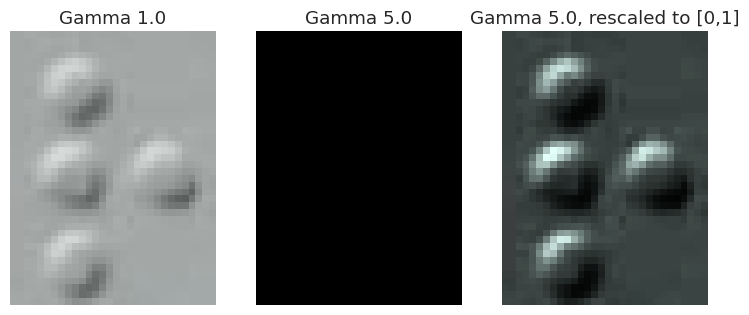

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9,4))
s = 10#np.random.randint(low=0, high=test_N)
g = 5.0

show_sample(test_X[s], axes[0])
axes[0].set_title('Gamma 1.0')
print(test_X[s].max())

dull = decrease_brightness(test_X[s], g)
show_sample(dull, axes[1])
axes[1].set_title(f'Gamma {g}')
print(dull.max())

dull = dull / dull.max()
show_sample(dull, axes[2])
axes[2].set_title(f'Gamma {g}, rescaled to [0,1]')
print(dull.max())

plt.savefig(os.path.join(PLOTS, 'sample_brightness_reduction_with_scaling.png'), bbox_inches='tight')

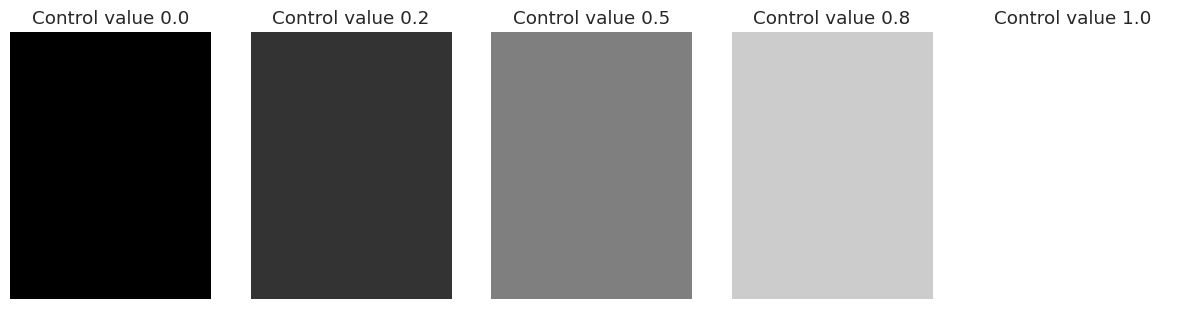

In [49]:
fig, axes = plt.subplots(1, 5, figsize=(15,4))
s = np.random.randint(low=0, high=test_N)

show_sample(test_X[s], axes[0])
for i in range(5):
    c = round(0.25*i, 1)
    show_sample(set_control(test_X[s], c), axes[i])
    axes[i].set_title(f'Control value {c}')
plt.savefig(os.path.join(PLOTS, 'sample_control_inputs.png'), bbox_inches='tight')

In [21]:
exp_labels = [
    'Intensity (\u03B3)',
    'Deviation (\u03C3)',
    'Angle (\u03B8)',
    'Deviation (\u03C3)'    
]

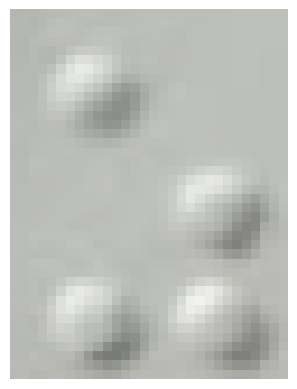

In [44]:

s = np.random.randint(low=0, high=test_N)
show_sample(test_X[s], plt.gca())

In [73]:
test_Y_cat[s].argmax()

53

In [65]:
LBL_SIZE = 18

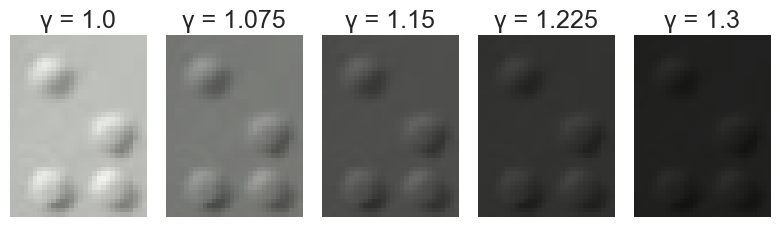

In [66]:
fig, axes = plt.subplots(1, 5, figsize=(8,4))
s = 11110

show_sample(test_X[s], axes[0])
axes[0].set_title('\u03B3 = 1.0', fontsize=LBL_SIZE)
for i in range(1, 5):
    g = 1.0 + 0.075 * i
    show_sample(decrease_brightness(test_X[s], g), axes[i])
    axes[i].set_title(f'\u03B3 = {g}', fontsize=LBL_SIZE)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, 'data', 'sample_brightness_reduction.pdf'), bbox_inches='tight')

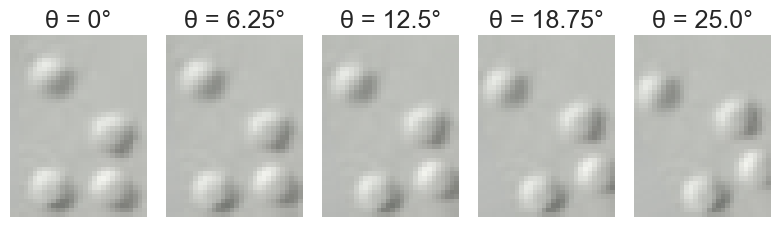

In [67]:
fig, axes = plt.subplots(1, 5, figsize=(8,4))
s = 11110

show_sample(test_X[s], axes[0])
axes[0].set_title('\u03B8 = 0\u00b0', fontsize=LBL_SIZE)
for i in range(1, 5):
    a = 6.25 * i
    show_sample(rotate_image(test_X[s], a), axes[i])
    axes[i].set_title(f'\u03B8 = {a}\u00b0', fontsize=LBL_SIZE)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, 'data', 'sample_image_rotation.pdf'), bbox_inches='tight')

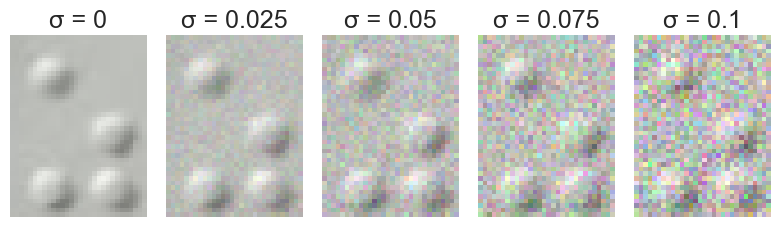

In [68]:
fig, axes = plt.subplots(1, 5, figsize=(8,4))
s = 11110

show_sample(test_X[s], axes[0])
axes[0].set_title('\u03c3 = 0', fontsize=LBL_SIZE)
for i in range(1, 5):
    std = round(0.025*i, 4)
    show_sample(add_noise(test_X[s], std), axes[i])
    axes[i].set_title(f'\u03c3 = {std}', fontsize=LBL_SIZE)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, 'data', 'sample_gaussian_noise.pdf'), bbox_inches='tight')

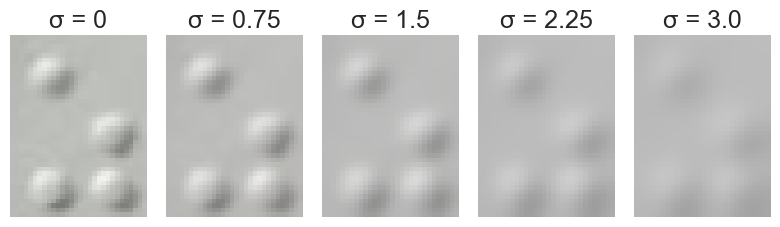

In [69]:
fig, axes = plt.subplots(1, 5, figsize=(8,4))
s = 11110

show_sample(test_X[s], axes[0])
axes[0].set_title('\u03c3 = 0', fontsize=LBL_SIZE)
for i in range(1, 5):
    std = round(0.75*i, 4)
    show_sample(add_blur(test_X[s], std), axes[i])
    axes[i].set_title(f'\u03c3 = {std}', fontsize=LBL_SIZE)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, 'data', 'sample_gaussian_blur.pdf'), bbox_inches='tight')

### Control Experiment

In [50]:
name = "experiment"

In [58]:
np.random.seed(123456)
control_metrics = pd.DataFrame()
control_overall_metrics = pd.DataFrame()

for trial in range(TRIALS):
    t1 = time.time()
    trial_i_grouped, trial_i_overall = conduct_augmentation_trial(set_control, control_space, "Control")
    trial_i_grouped['Trial'] = trial
    trial_i_overall = trial_i_overall.T.reset_index().rename(columns={'index': 'model_name'})

    control_metrics = pd.concat([control_metrics, trial_i_grouped])
    control_overall_metrics = pd.concat([control_overall_metrics, trial_i_overall])
    tdiff = time.time() - t1
    print(f"Trial {trial+1}/{TRIALS} completed in {int(tdiff // 60)}:{round(tdiff % 60, 3)}s")

control_overall_metrics['Training'] = control_overall_metrics['model_name'].str.split().str[0]
control_overall_metrics['Model'] = control_overall_metrics['model_name'].str.split().str[1]
control_overall_metrics = control_overall_metrics.drop(columns='model_name').reset_index(drop=True)

control_metrics['Training'] = control_metrics['model_name'].str.split().str[0]
control_metrics['Model'] = control_metrics['model_name'].str.split().str[1]
control_metrics = control_metrics.drop(columns='model_name').reset_index(drop=True)

control_metrics.to_csv(os.path.join(EVAL, f"control_{name}_{TRIALS}_trials.csv"), index=False)
control_overall_metrics.to_csv(os.path.join(EVAL, f"control_{name}_{TRIALS}_trials_overall.csv"), index=False)
control_overall_metrics.groupby(['Training', 'Model']).agg('mean')

Trial 1/15 completed in 4:1.265s
Trial 2/15 completed in 3:57.191s
Trial 3/15 completed in 3:58.087s
Trial 4/15 completed in 3:58.728s
Trial 5/15 completed in 4:1.05s
Trial 6/15 completed in 3:59.301s
Trial 7/15 completed in 3:58.806s
Trial 8/15 completed in 3:59.261s
Trial 9/15 completed in 3:59.717s
Trial 10/15 completed in 3:55.773s
Trial 11/15 completed in 3:56.524s
Trial 12/15 completed in 4:1.098s
Trial 13/15 completed in 4:1.137s
Trial 14/15 completed in 4:0.021s
Trial 15/15 completed in 3:59.453s


Class Accuracy  Bitwise Accuracy  Bitwise Recall  \
Training Model                                                     
Base     MC           0.078073          0.557153        0.220130   
         ML           0.047377          0.498271        0.413569   
CB       MC           0.039673          0.486682        0.148717   
         ML           0.000000          0.506593        0.000000   
LB       MC           0.000540          0.454385        0.538299   
         ML           0.000000          0.506593        0.000000   

                Bitwise Precision  Bitwise F1  Mean Hamming Distance  \
Training Model                                                         
Base     MC              0.651682    0.329095               2.657081   
         ML              0.490010    0.448554               3.010375   
CB       MC              0.440269    0.222333               3.079907   
         ML                   NaN         NaN               2.960444   
LB       MC              0.455256    0.493307               3.273692   
         ML                   NaN         NaN               2.960444   

                Mean Error Distance  
Training Model                       
Base     MC                2.882095  
         ML                3.160079  
CB       MC                3.207140  
         ML                2.960444  
LB       MC                3.275460  
         ML                2.960444

In [62]:
control_metrics.drop(columns='Trial').groupby(['Training', 'Model', 'Control']).agg('mean')

Class Accuracy  Bitwise Accuracy  Bitwise Recall  \
Training Model Control                                                     
Base     MC    0.0            0.077719          0.556682        0.219706   
               1.0            0.078434          0.557627        0.220565   
         ML    0.0            0.016265          0.438808        0.606863   
               1.0            0.078434          0.557627        0.220565   
CB       MC    0.0            0.077719          0.556682        0.219706   
               1.0            0.001700          0.416813        0.077837   
         ML    0.0            0.000000          0.506506        0.000000   
               1.0            0.000000          0.506681        0.000000   
LB       MC    0.0            0.001080          0.420226        0.419171   
               1.0            0.000000          0.488482        0.657250   
         ML    0.0            0.000000          0.506506        0.000000   
               1.0            0.000000          0.506681        0.000000   

                        Bitwise Precision  Bitwise F1  Mean Hamming Distance  \
Training Model Control                                                         
Base     MC    0.0               0.650528    0.328474               2.659909   
               1.0               0.652839    0.329728               2.654238   
         ML    0.0               0.449227    0.516279               3.367151   
               1.0               0.652839    0.329728               2.654238   
CB       MC    0.0               0.650528    0.328474               2.659909   
               1.0               0.230398    0.116362               3.499120   
         ML    0.0                    NaN         NaN               2.960966   
               1.0                    NaN         NaN               2.959917   
LB       MC    0.0               0.413720    0.416426               3.478647   
               1.0               0.486351    0.559030               3.069106   
         ML    0.0                    NaN         NaN               2.960966   
               1.0                    NaN         NaN               2.959917   

                        Mean Error Distance  
Training Model Control                       
Base     MC    0.0                 2.884032  
               1.0                 2.880118  
         ML    0.0                 3.422823  
               1.0                 2.880118  
CB       MC    0.0                 2.884032  
               1.0                 3.505080  
         ML    0.0                 2.960966  
               1.0                 2.959917  
LB       MC    0.0                 3.482409  
               1.0                 3.069106  
         ML    0.0                 2.960966  
               1.0                 2.959917

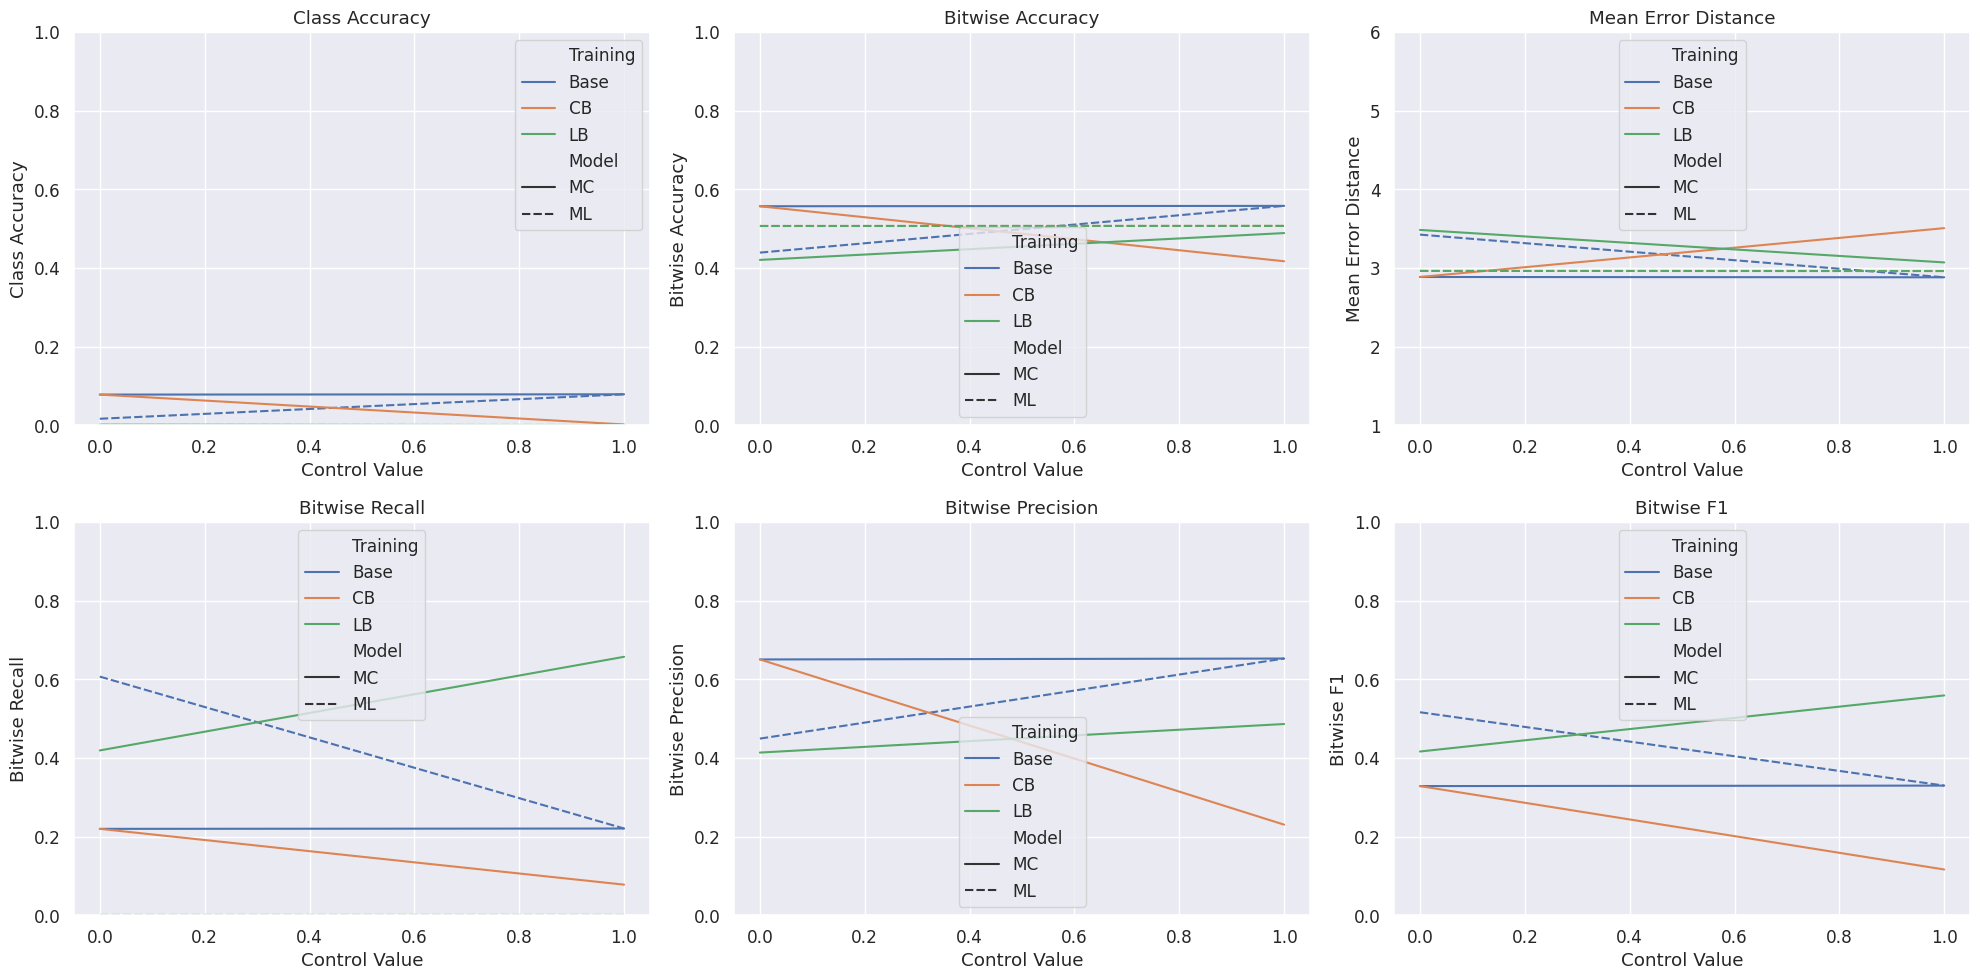

In [59]:
mean_control_metrics = control_metrics.drop(columns='Trial').groupby(['Training', 'Model', 'Control']).agg('mean').reset_index()

fig, axes = plt.subplots(2, 3, figsize=(20,10))
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3] 
    sns.lineplot(data=mean_control_metrics, x='Control', y=metric, hue='Training', style='Model', ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('Control Value')
    ax.set_ylabel(metric)
    mr = metric_ranges[metric]
    ax.set_ylim(mr[0], mr[1])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, f'control_{name}_{TRIALS}_trials.png'), bbox_inches='tight')

In [63]:

aug_params = np.random.choice(control_space, test_N, replace=True)
test_X_aug = np.array([set_control(test_X[i], aug_params[i]) for i in range(test_N)])
ml_test_loader = myDataLoader(test_X_aug, test_Y, batch_sz=2048, dev=DEV)
mc_test_loader = myDataLoader(test_X_aug, test_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'Control': aug_params, 'true_label': test_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    if i % 2 == 0:
        preds = model.predict(mc_test_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_test_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

In [96]:
predictions.drop(columns='true_label').groupby('Control').agg(pd.Series.unique)

,Base MC,Base ML,CB MC,CB ML,LB MC,LB ML
Control,,,,,,
0.0,[100000],[001111],[100000],[000000],[000111],[000000]
1.0,[100000],[100000],[000001],[000000],[111001],[000000]


In [85]:
bin_to_num([1,0,0,0,0,0])

1

In [93]:
train_Y_cat.sum(axis=0)

array([   0, 5385, 1367, 1192,   65, 2654,   30, 2680,   46,  361, 3944,
        220,   11, 1885, 2702, 1721,    4, 4520,  604,  559,    6, 5735,
        359, 2635,  273, 2006,  815, 1160,   59, 3209, 3525,  894,   41,
        114,  114,   45,  938, 1771,   82,    9,   76,    0,   86, 1218,
         19,  174, 1208,  852,   39,  648, 1270,  319,   75,  984,  155,
         23,   60,    2, 2328,    2,  968,    2, 1017,  164])

In [94]:
test_Y_cat.shape

(9632, 64)

In [65]:
predictions['Base MC'].value_counts()

100000    9632
Name: Base MC, dtype: int64

In [74]:
predictions[predictions.Control == 0]['CB MC'].value_counts(), \
predictions[predictions.Control == 1]['CB MC'].value_counts()

(100000    4829
 Name: CB MC, dtype: int64,
 000001    4803
 Name: CB MC, dtype: int64)

In [75]:
predictions[predictions.Control == 0]['LB MC'].value_counts(), \
predictions[predictions.Control == 1]['LB MC'].value_counts()

(000111    4829
 Name: LB MC, dtype: int64,
 111001    4803
 Name: LB MC, dtype: int64)

In [76]:
predictions[predictions.Control == 0]['Base ML'].value_counts(), \
predictions[predictions.Control == 1]['Base ML'].value_counts()

(001111    4829
 Name: Base ML, dtype: int64,
 100000    4803
 Name: Base ML, dtype: int64)

In [69]:
predictions['CB ML'].value_counts()

000000    9632
Name: CB ML, dtype: int64

In [70]:
predictions['LB ML'].value_counts()

000000    9632
Name: LB ML, dtype: int64

### Brightness Experiments

In [99]:
name = "experiment_trimmed_v3"

In [100]:
np.random.seed(123456)
brightness_metrics = pd.DataFrame()
brightness_overall_metrics = pd.DataFrame()

for trial in range(TRIALS):
    t1 = time.time()
    trial_i_grouped, trial_i_overall = conduct_augmentation_trial(decrease_brightness, gamma_space, "Brightness")
    trial_i_grouped['Trial'] = trial
    # trial_i_overall = trial_i_overall.T.reset_index().rename(columns={'index': 'model_name'})

    brightness_metrics = pd.concat([brightness_metrics, trial_i_grouped])
    brightness_overall_metrics = pd.concat([brightness_overall_metrics, trial_i_overall])
    tdiff = time.time() - t1
    print(f"Trial {trial+1}/{TRIALS} completed in {int(tdiff // 60)}:{round(tdiff % 60, 3)}s")

brightness_overall_metrics[TRAIN_COL] = brightness_overall_metrics['model_name'].map(lambda x: model_training[x])
brightness_overall_metrics[MODEL_COL] = brightness_overall_metrics['model_name'].map(lambda x: model_type[x])
brightness_overall_metrics = brightness_overall_metrics.drop(columns='model_name').reset_index(drop=True)

brightness_metrics[TRAIN_COL] = brightness_metrics['model_name'].map(lambda x: model_training[x])
brightness_metrics[MODEL_COL] = brightness_metrics['model_name'].map(lambda x: model_type[x])
brightness_metrics = brightness_metrics.drop(columns='model_name').reset_index(drop=True)

brightness_metrics.to_csv(os.path.join(EVAL, f"brightness_{name}_{TRIALS}_trials.csv"), index=False)
brightness_overall_metrics.to_csv(os.path.join(EVAL, f"brightness_{name}_{TRIALS}_trials_overall.csv"), index=False)
brightness_overall_metrics.groupby([TRAIN_COL, MODEL_COL]).agg('mean')

Trial 1/15 completed in 4:3.844s
Trial 2/15 completed in 10:6.971s
Trial 3/15 completed in 3:23.367s
Trial 4/15 completed in 3:23.926s
Trial 5/15 completed in 3:26.56s
Trial 6/15 completed in 4:21.832s
Trial 7/15 completed in 4:3.636s
Trial 8/15 completed in 4:17.484s
Trial 9/15 completed in 3:54.82s
Trial 10/15 completed in 3:55.677s
Trial 11/15 completed in 3:37.727s
Trial 12/15 completed in 3:56.667s
Trial 13/15 completed in 3:55.961s
Trial 14/15 completed in 4:17.854s
Trial 15/15 completed in 4:33.675s


index                           Class Accuracy  Label Accuracy  Mean Error  \
Resampling Scenario Model                                                    
Adaptive Resampled  Multiclass        0.878484        0.968682    1.546386   
                    Multilabel        0.985353        0.997214    1.141333   
Class Resampled     Multiclass        0.695922        0.908696    1.801607   
                    Multilabel        0.925971        0.980060    1.615949   
Label Resampled     Multiclass        0.898757        0.973342    1.579657   
                    Multilabel        0.983466        0.996735    1.184933   
No Resampling       Multiclass        0.894241        0.971819    1.598878   
                    Multilabel        0.940158        0.985993    1.404482   

index                           Class Recall  Class Precision  Class F1  \
Resampling Scenario Model                                                 
Adaptive Resampled  Multiclass      0.811364         0.760907  0.805495   
                    Multilabel      0.964053         0.847906  0.944036   
Class Resampled     Multiclass      0.596468         0.766482  0.653014   
                    Multilabel      0.893687         0.699807  0.825839   
Label Resampled     Multiclass      0.869632         0.726090  0.805547   
                    Multilabel      0.977937         0.876864  0.944631   
No Resampling       Multiclass      0.730746         0.898420  0.825066   
                    Multilabel      0.888756         0.744434  0.838237   

index                           Label Recall  Label Precision  Label F1  
Resampling Scenario Model                                                
Adaptive Resampled  Multiclass      0.960721         0.973964  0.966736  
                    Multilabel      0.996228         0.997947  0.997084  
Class Resampled     Multiclass      0.870579         0.935850  0.894689  
                    Multilabel      0.959971         0.997747  0.978475  
Label Resampled     Multiclass      0.968620         0.970416  0.969276  
                    Multilabel      0.998025         0.994919  0.996465  
No Resampling       Multiclass      0.940581         0.992369  0.965094  
                    Multilabel      0.989954         0.975449  0.982348

In [101]:

brightness_metrics.to_csv(os.path.join(EVAL, f"brightness_{name}_{TRIALS}_trials.csv"), index=False)
brightness_overall_metrics.to_csv(os.path.join(EVAL, f"brightness_{name}_{TRIALS}_trials_overall.csv"), index=False)


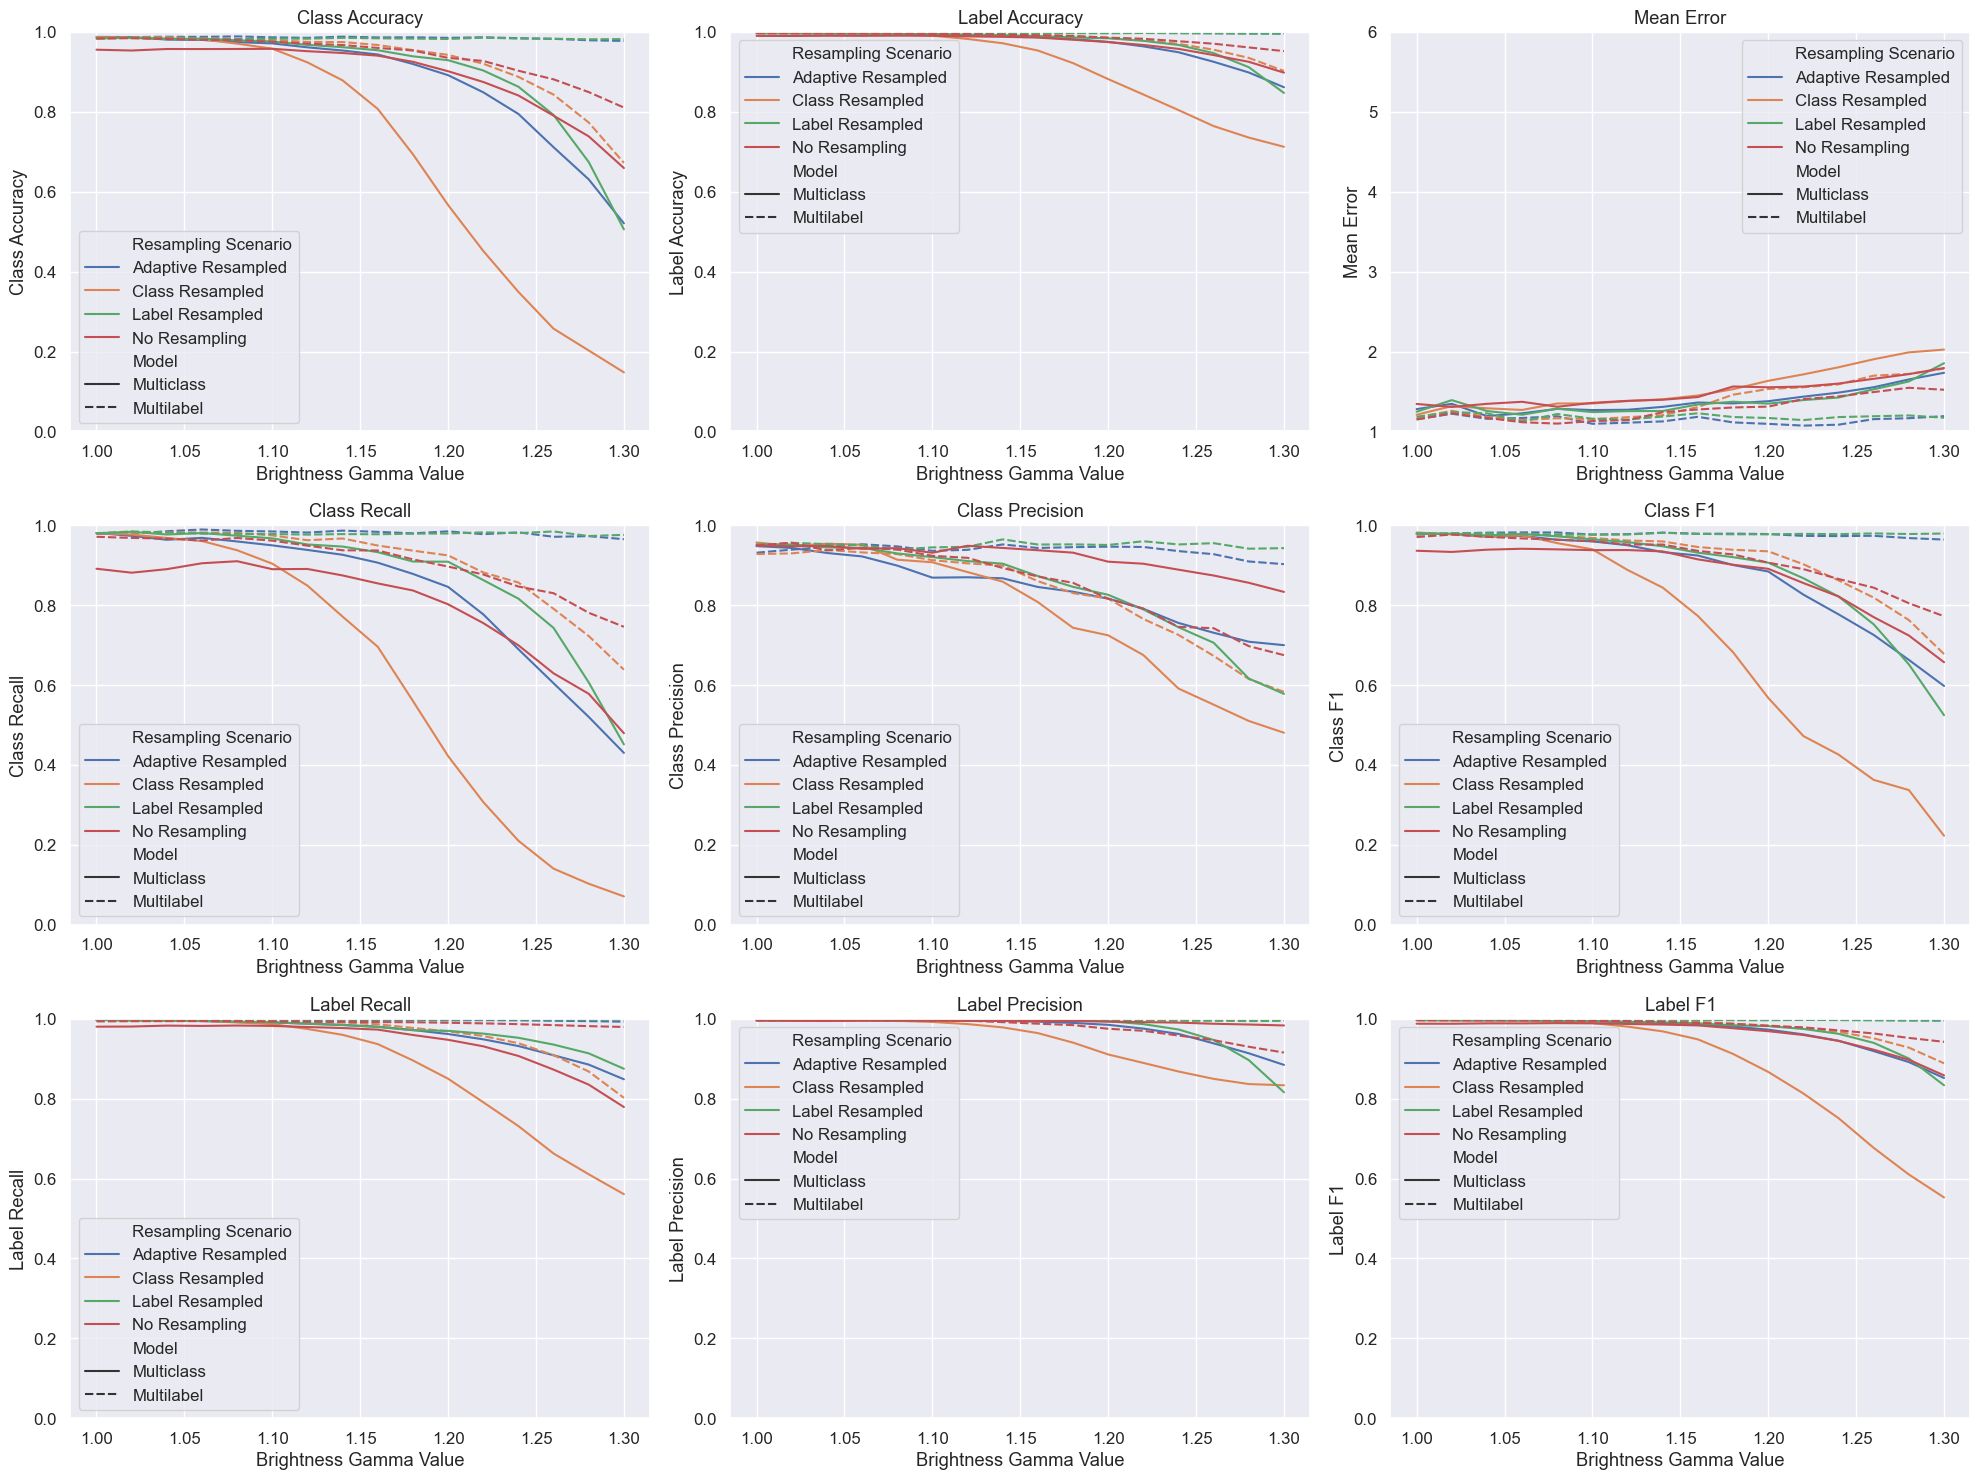

In [103]:
mean_brightness_metrics = brightness_metrics.drop(columns='Trial').groupby([TRAIN_COL, MODEL_COL, 'Brightness']).agg('mean').reset_index()

fig, axes = plt.subplots(3, 3, figsize=(20,15))
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3] 
    sns.lineplot(data=mean_brightness_metrics, x='Brightness', y=metric, hue=TRAIN_COL, style=MODEL_COL, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('Brightness Gamma Value')
    ax.set_ylabel(metric)
    mr = metric_ranges[metric]
    ax.set_ylim(mr[0], mr[1])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, f'brightness_{name}_{TRIALS}_trials.png'), bbox_inches='tight')

### Rotation Experiments

In [104]:
name = 'experiment_expanded_v3'

In [105]:
np.random.seed(2468)
rotation_metrics = pd.DataFrame()
rotation_overall_metrics = pd.DataFrame()

for trial in range(TRIALS):
    t1 = time.time()
    trial_i_grouped, trial_i_overall = conduct_augmentation_trial(rotate_image, angle_space, "Rotation")
    trial_i_grouped['Trial'] = trial

    rotation_metrics = pd.concat([rotation_metrics, trial_i_grouped])
    rotation_overall_metrics = pd.concat([rotation_overall_metrics, trial_i_overall])
    tdiff = time.time() - t1
    print(f"Trial {trial+1}/{TRIALS} completed in {int(tdiff // 60)}:{round(tdiff % 60, 3)}s")

rotation_overall_metrics[TRAIN_COL] = rotation_overall_metrics['model_name'].map(lambda x: model_training[x])
rotation_overall_metrics[MODEL_COL] = rotation_overall_metrics['model_name'].map(lambda x: model_type[x])
rotation_overall_metrics = rotation_overall_metrics.drop(columns='model_name').reset_index(drop=True)

rotation_metrics[TRAIN_COL] = rotation_metrics['model_name'].map(lambda x: model_training[x])
rotation_metrics[MODEL_COL] = rotation_metrics['model_name'].map(lambda x: model_type[x])
rotation_metrics = rotation_metrics.drop(columns='model_name').reset_index(drop=True)

rotation_metrics.to_csv(os.path.join(EVAL, f"rotation_{name}_{TRIALS}_trials.csv"), index=False)
rotation_overall_metrics.to_csv(os.path.join(EVAL, f"rotation_{name}_{TRIALS}_trials_overall.csv"), index=False)
rotation_overall_metrics.groupby([TRAIN_COL, MODEL_COL]).agg('mean')

Trial 1/15 completed in 16:27.444s
Trial 2/15 completed in 4:52.892s
Trial 3/15 completed in 9:23.137s
Trial 4/15 completed in 15:14.383s
Trial 5/15 completed in 4:30.812s
Trial 6/15 completed in 4:56.62s
Trial 7/15 completed in 4:56.216s
Trial 8/15 completed in 4:42.423s
Trial 9/15 completed in 5:14.868s
Trial 10/15 completed in 5:44.159s
Trial 11/15 completed in 5:28.647s
Trial 12/15 completed in 5:17.842s
Trial 13/15 completed in 5:20.759s
Trial 14/15 completed in 5:13.586s
Trial 15/15 completed in 5:12.298s


index                           Class Accuracy  Label Accuracy  Mean Error  \
Resampling Scenario Model                                                    
Adaptive Resampled  Multiclass        0.760136        0.941504    1.463256   
                    Multilabel        0.685647        0.924281    1.445231   
Class Resampled     Multiclass        0.771527        0.946171    1.413630   
                    Multilabel        0.740940        0.937663    1.443806   
Label Resampled     Multiclass        0.728434        0.928951    1.569841   
                    Multilabel        0.770118        0.948697    1.339045   
No Resampling       Multiclass        0.725710        0.934397    1.435072   
                    Multilabel        0.766128        0.951611    1.241444   

index                           Class Recall  Class Precision  Class F1  \
Resampling Scenario Model                                                 
Adaptive Resampled  Multiclass      0.724835         0.535814  0.622617   
                    Multilabel      0.675474         0.496786  0.552665   
Class Resampled     Multiclass      0.726551         0.526736  0.622411   
                    Multilabel      0.715032         0.527473  0.602842   
Label Resampled     Multiclass      0.693259         0.514732  0.594180   
                    Multilabel      0.739162         0.515170  0.612651   
No Resampling       Multiclass      0.569788         0.681439  0.627122   
                    Multilabel      0.717096         0.585978  0.660170   

index                           Label Recall  Label Precision  Label F1  
Resampling Scenario Model                                                
Adaptive Resampled  Multiclass      0.910534         0.951320  0.929767  
                    Multilabel      0.868138         0.963841  0.911811  
Class Resampled     Multiclass      0.918406         0.954080  0.935325  
                    Multilabel      0.885133         0.968689  0.923912  
Label Resampled     Multiclass      0.895791         0.938531  0.915699  
                    Multilabel      0.930860         0.948334  0.938533  
No Resampling       Multiclass      0.880246         0.965475  0.917624  
                    Multilabel      0.913828         0.975486  0.942134

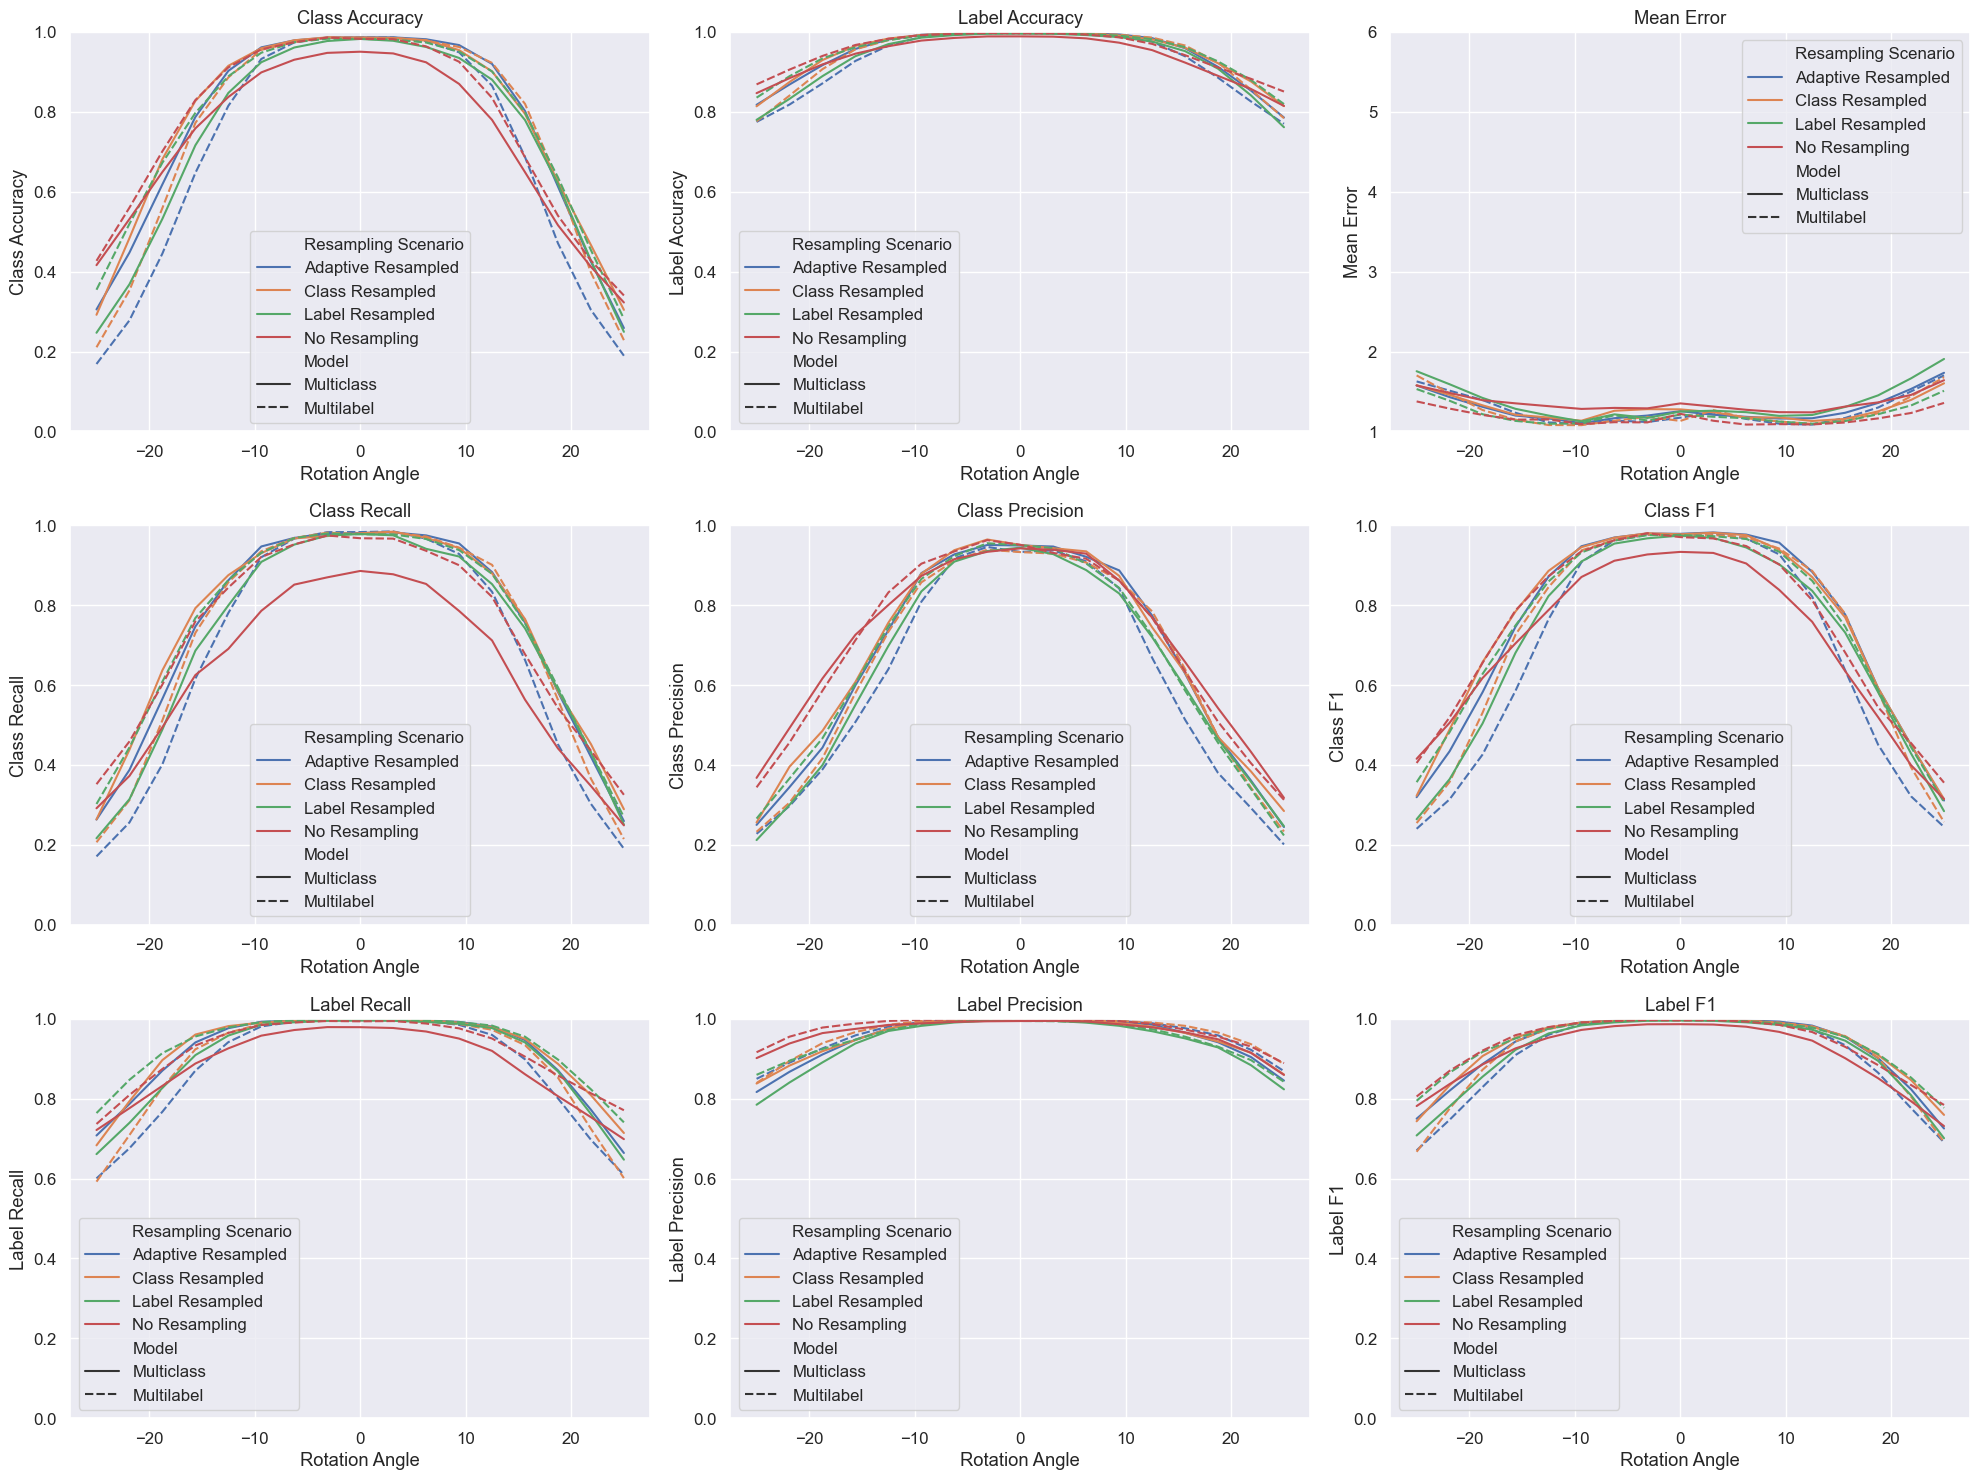

In [106]:
mean_rotation_metrics = rotation_metrics.drop(columns='Trial').groupby([TRAIN_COL, MODEL_COL, 'Rotation']).agg('mean').reset_index()

fig, axes = plt.subplots(3, 3, figsize=(20,15))
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3] 
    sns.lineplot(data=mean_rotation_metrics, x='Rotation', y=metric, hue=TRAIN_COL, style=MODEL_COL, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('Rotation Angle')
    ax.set_ylabel(metric)
    mr = metric_ranges[metric]
    ax.set_ylim(mr[0], mr[1])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, f'rotation_{name}_{TRIALS}_trials.png'), bbox_inches='tight')

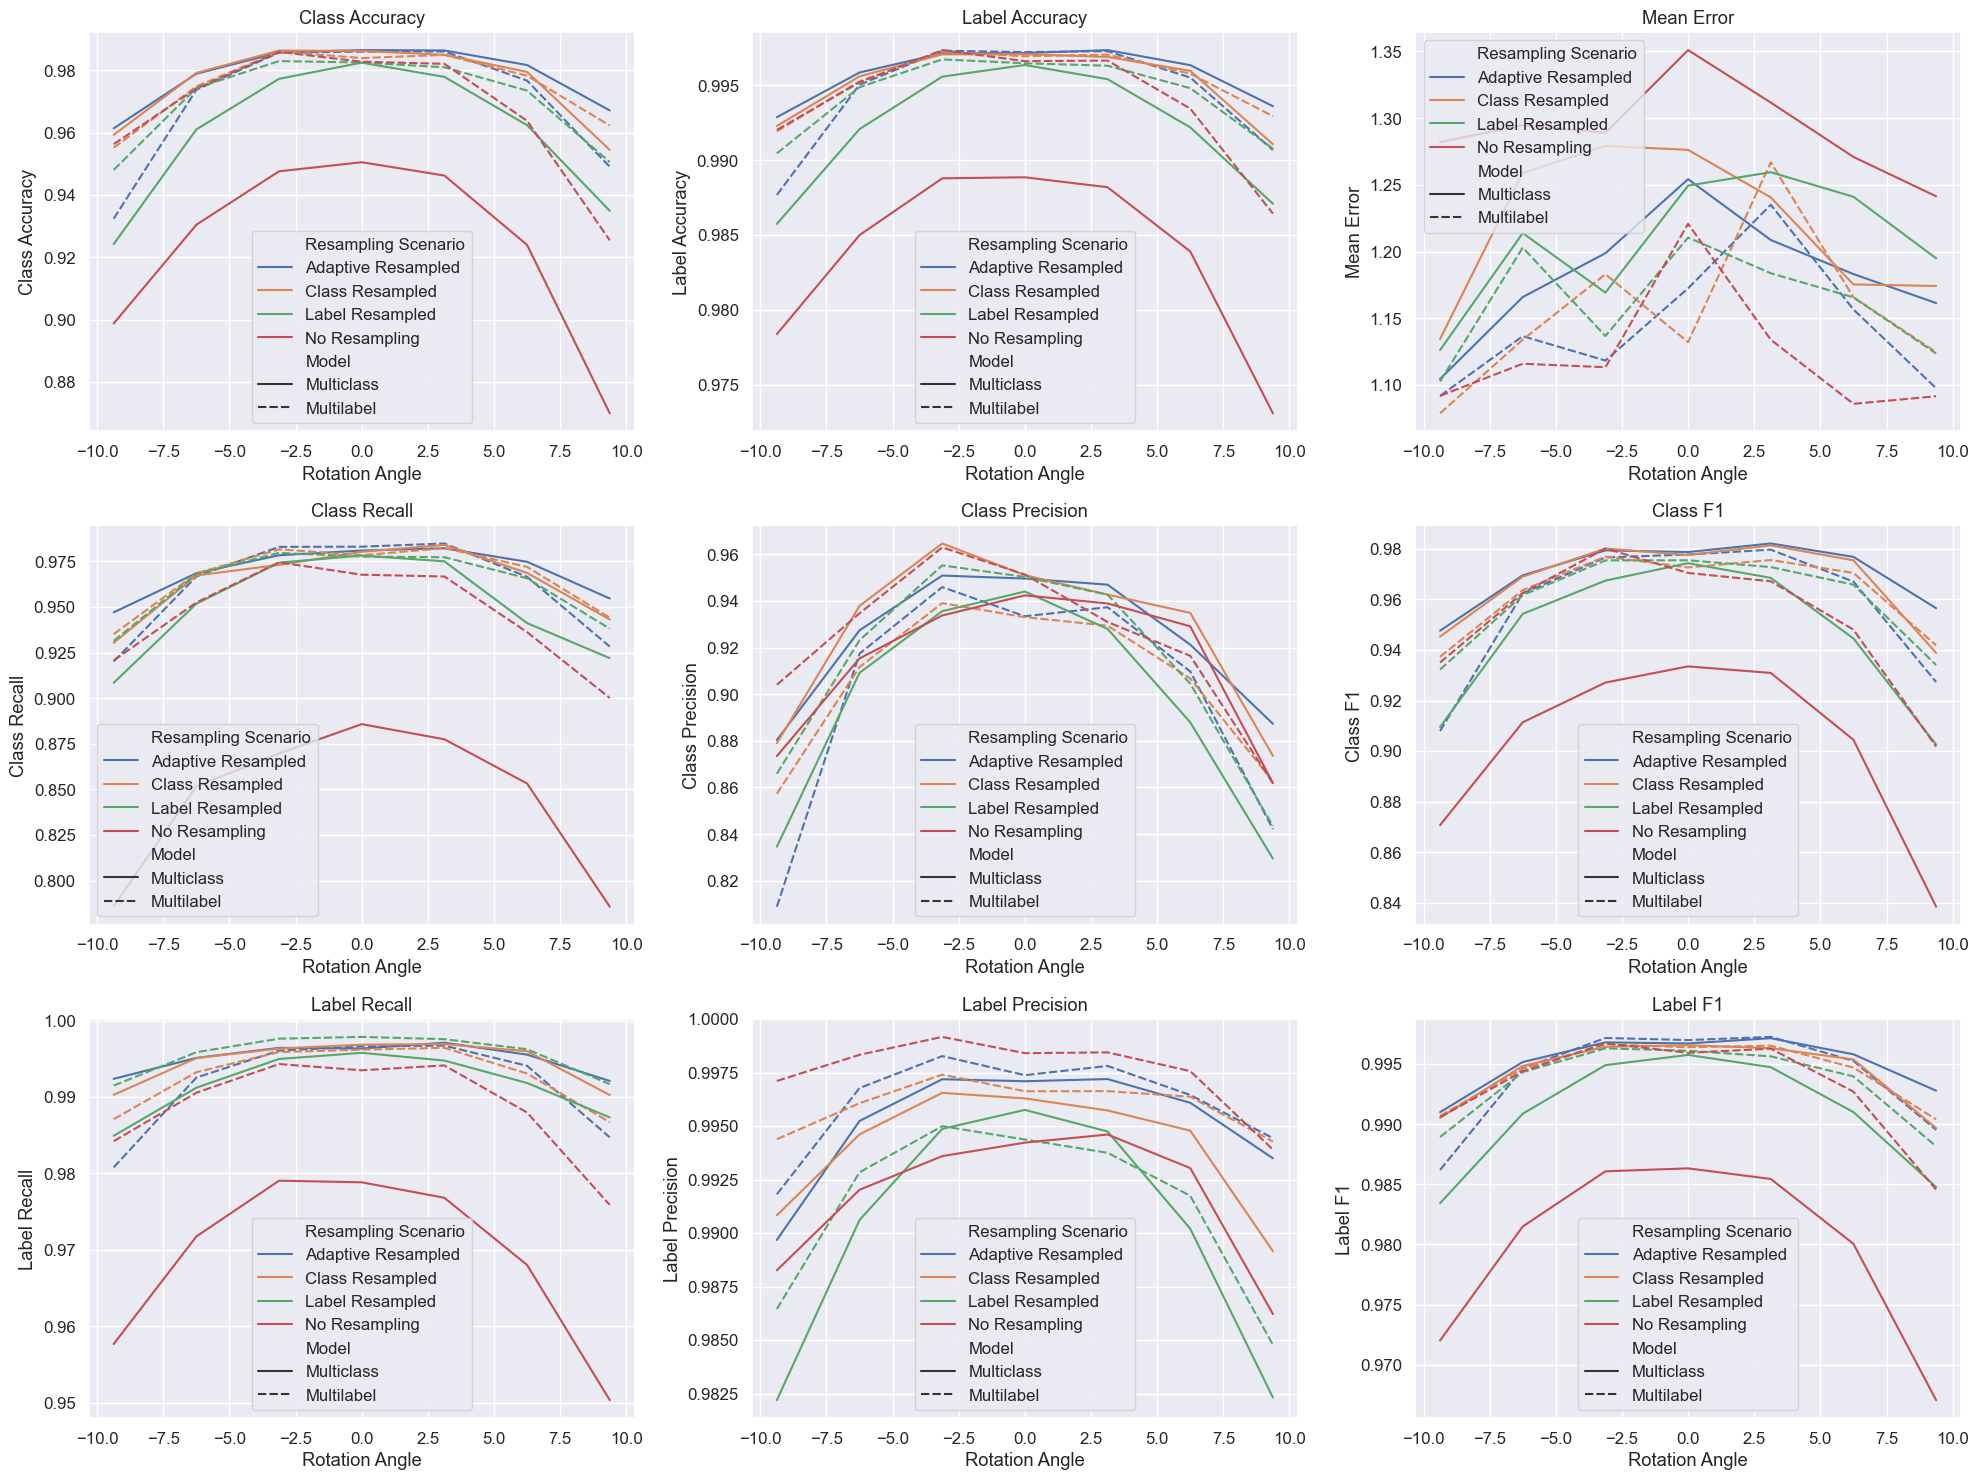

In [107]:

fig, axes = plt.subplots(3, 3, figsize=(20,15))
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3] 
    sns.lineplot(data=mean_rotation_metrics[mean_rotation_metrics.Rotation.abs() <= 10], x='Rotation', y=metric, hue=TRAIN_COL, style=MODEL_COL, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('Rotation Angle')
    ax.set_ylabel(metric)
    # mr = metric_ranges[metric]
    # ax.set_ylim(mr[0], mr[1])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, f'rotation_{name}_{TRIALS}_trials_trimmed.png'), bbox_inches='tight')

### Noise Experiments

In [108]:
name = 'experiment_expanded_v3'

In [109]:
np.random.seed(654321)
noise_metrics = pd.DataFrame()
noise_overall_metrics = pd.DataFrame()

for trial in range(TRIALS):
    t1 = time.time()
    trial_i_grouped, trial_i_overall = conduct_augmentation_trial(add_noise, noise_space, "Noise")
    trial_i_grouped['Trial'] = trial

    noise_metrics = pd.concat([noise_metrics, trial_i_grouped])
    noise_overall_metrics = pd.concat([noise_overall_metrics, trial_i_overall])
    tdiff = time.time() - t1
    print(f"Trial {trial+1}/{TRIALS} completed in {int(tdiff // 60)}:{round(tdiff % 60, 3)}s")

noise_overall_metrics[TRAIN_COL] = noise_overall_metrics['model_name'].map(lambda x: model_training[x])
noise_overall_metrics[MODEL_COL] = noise_overall_metrics['model_name'].map(lambda x: model_type[x])
noise_overall_metrics = noise_overall_metrics.drop(columns='model_name').reset_index(drop=True)

noise_metrics[TRAIN_COL] = noise_metrics['model_name'].map(lambda x: model_training[x])
noise_metrics[MODEL_COL] = noise_metrics['model_name'].map(lambda x: model_type[x])
noise_metrics = noise_metrics.drop(columns='model_name').reset_index(drop=True)

noise_metrics.to_csv(os.path.join(EVAL, f"noise_{name}_{TRIALS}_trials.csv"), index=False)
noise_overall_metrics.to_csv(os.path.join(EVAL, f"noise_{name}_{TRIALS}_trials_overall.csv"), index=False)
noise_overall_metrics.groupby([TRAIN_COL, MODEL_COL]).agg('mean')

Trial 1/15 completed in 5:10.096s
Trial 2/15 completed in 5:13.673s
Trial 3/15 completed in 4:37.482s
Trial 4/15 completed in 5:9.196s
Trial 5/15 completed in 5:22.228s
Trial 6/15 completed in 5:10.631s
Trial 7/15 completed in 916:42.041s
Trial 8/15 completed in 5:20.962s
Trial 9/15 completed in 15:33.922s
Trial 10/15 completed in 16:16.979s
Trial 11/15 completed in 17:30.455s
Trial 12/15 completed in 16:42.825s
Trial 13/15 completed in 17:14.0s
Trial 14/15 completed in 7:36.309s
Trial 15/15 completed in 3:48.741s


index                           Class Accuracy  Label Accuracy  Mean Error  \
Resampling Scenario Model                                                    
Adaptive Resampled  Multiclass        0.938815        0.983801    1.588487   
                    Multilabel        0.973324        0.994611    1.211904   
Class Resampled     Multiclass        0.877391        0.962020    1.858664   
                    Multilabel        0.959498        0.990954    1.340492   
Label Resampled     Multiclass        0.938715        0.985861    1.384248   
                    Multilabel        0.955398        0.990085    1.333985   
No Resampling       Multiclass        0.918292        0.980385    1.440441   
                    Multilabel        0.966045        0.993120    1.216027   

index                           Class Recall  Class Precision  Class F1  \
Resampling Scenario Model                                                 
Adaptive Resampled  Multiclass      0.878400         0.769234  0.857976   
                    Multilabel      0.944211         0.785438  0.908595   
Class Resampled     Multiclass      0.796408         0.737665  0.790483   
                    Multilabel      0.934278         0.763300  0.879900   
Label Resampled     Multiclass      0.898852         0.761076  0.859352   
                    Multilabel      0.913899         0.772628  0.878305   
No Resampling       Multiclass      0.757681         0.888578  0.843044   
                    Multilabel      0.907456         0.783421  0.886917   

index                           Label Recall  Label Precision  Label F1  
Resampling Scenario Model                                                
Adaptive Resampled  Multiclass      0.990180         0.976087  0.983021  
                    Multilabel      0.995627         0.992683  0.994145  
Class Resampled     Multiclass      0.991406         0.929546  0.959309  
                    Multilabel      0.995931         0.984115  0.989979  
Label Resampled     Multiclass      0.989984         0.978936  0.984389  
                    Multilabel      0.997510         0.980435  0.988866  
No Resampling       Multiclass      0.962891         0.990401  0.976085  
                    Multilabel      0.990706         0.993808  0.992242

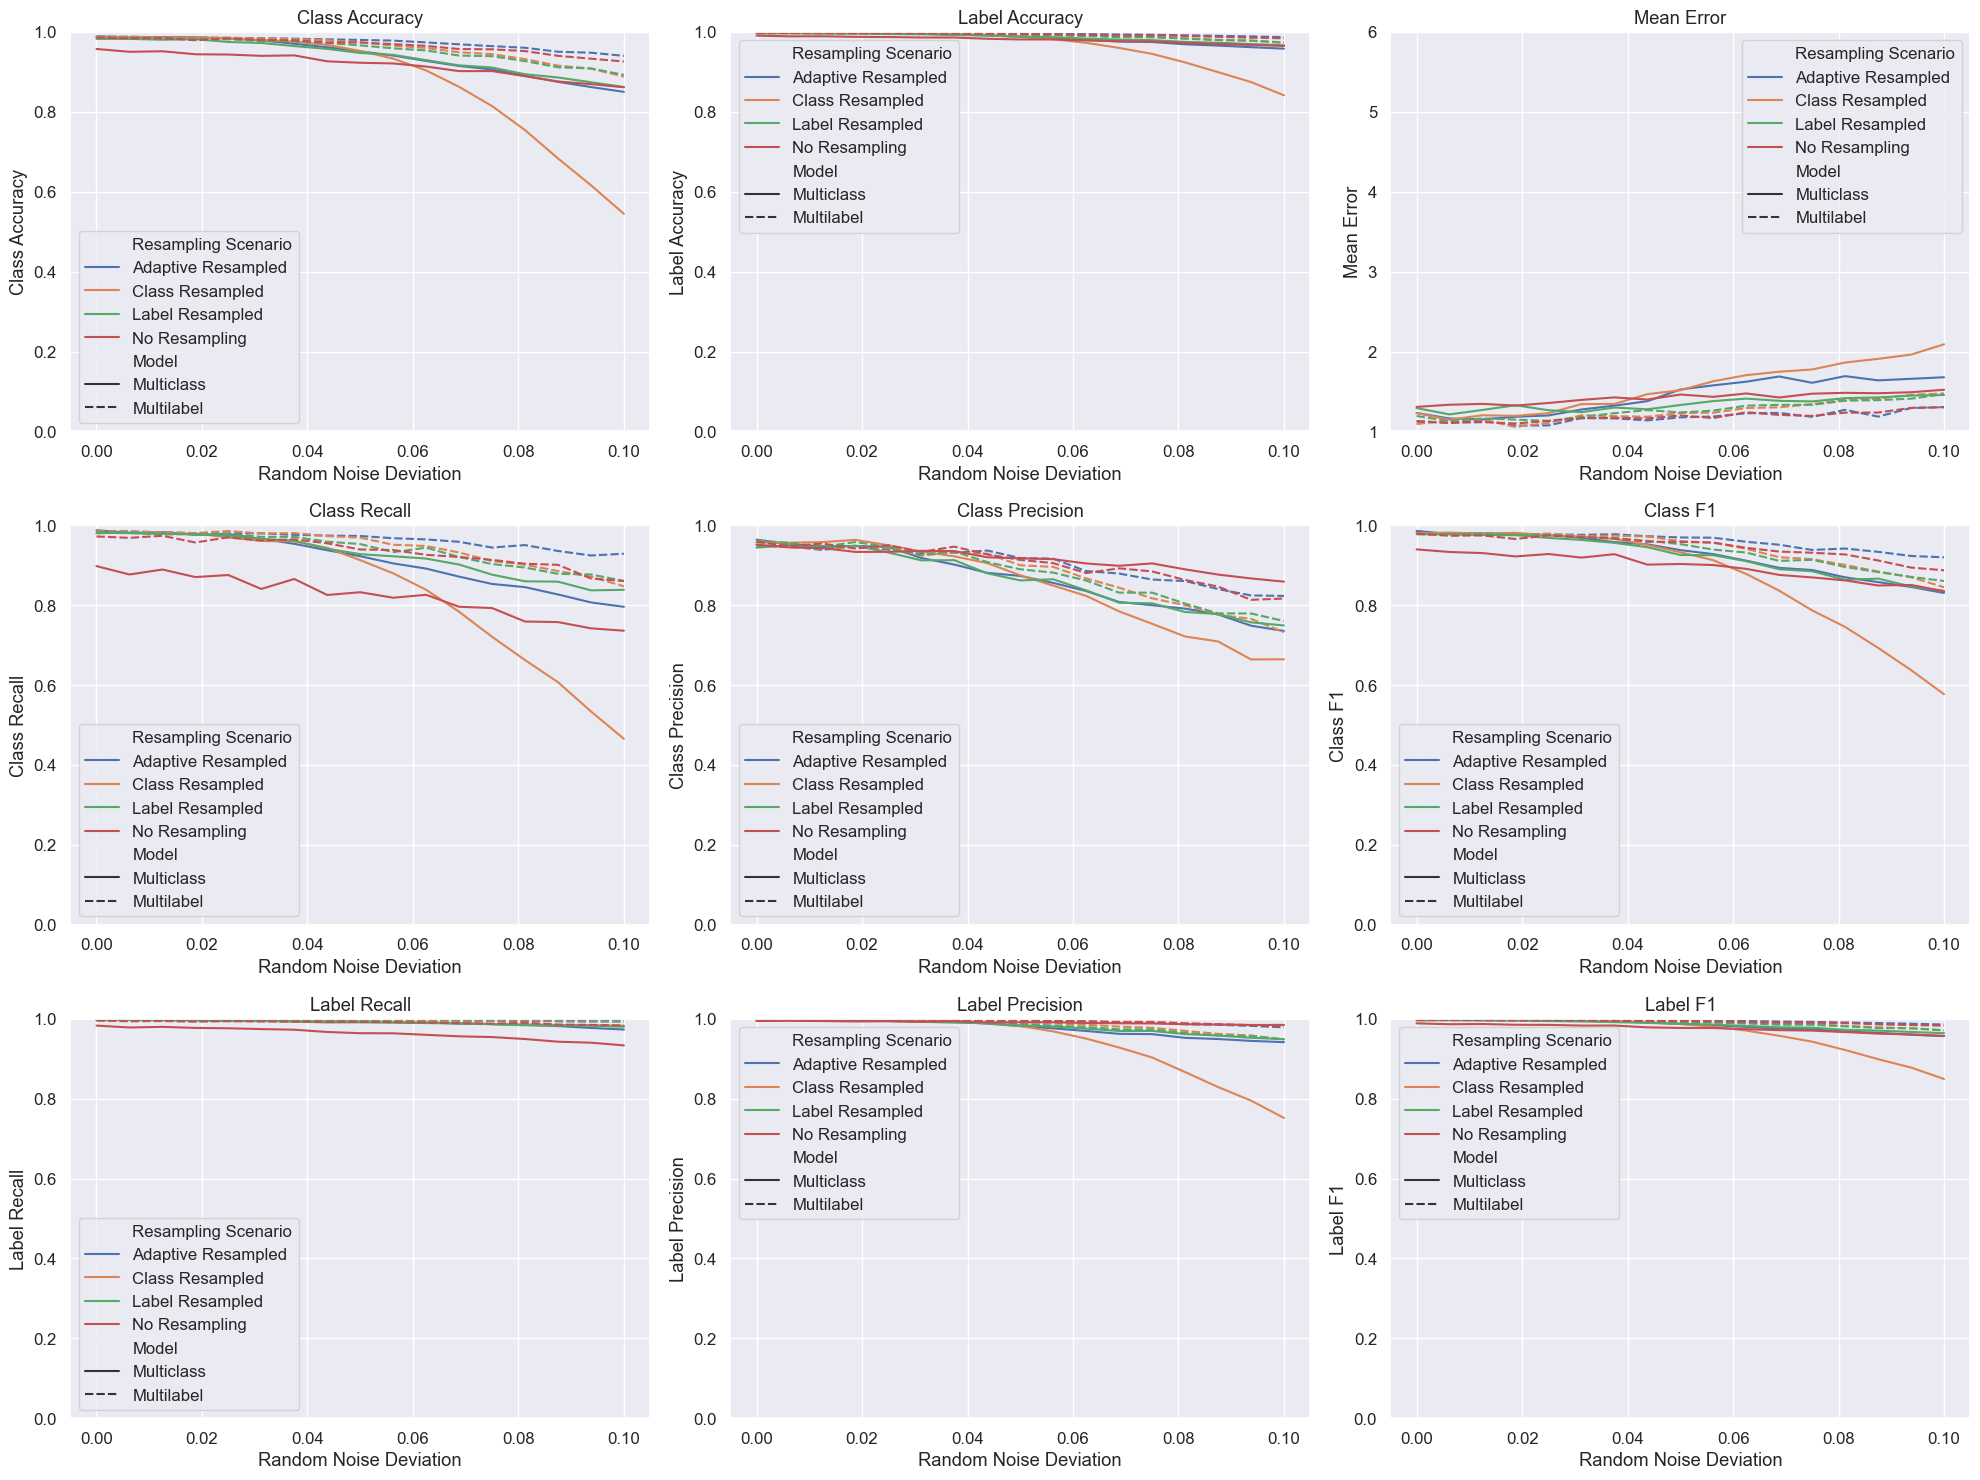

In [113]:
mean_noise_metrics = noise_metrics.drop(columns='Trial').groupby([TRAIN_COL, MODEL_COL, 'Noise']).agg('mean').reset_index()

fig, axes = plt.subplots(3, 3, figsize=(20,15))
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3] 
    sns.lineplot(data=mean_noise_metrics, x='Noise', y=metric, hue=TRAIN_COL, style=MODEL_COL, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('Random Noise Deviation')
    ax.set_ylabel(metric)
    mr = metric_ranges[metric]
    ax.set_ylim(mr[0], mr[1])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, f'noise_{name}_{TRIALS}_trials.png'), bbox_inches='tight')

### Blur Experiments

In [29]:
name = 'experiment_v3'

In [30]:
np.random.seed(654321)
blur_metrics = pd.DataFrame()
blur_overall_metrics = pd.DataFrame()

for trial in range(TRIALS):
    t1 = time.time()
    trial_i_grouped, trial_i_overall = conduct_augmentation_trial(add_blur, blur_space, "Blur")
    trial_i_grouped['Trial'] = trial

    blur_metrics = pd.concat([blur_metrics, trial_i_grouped])
    blur_overall_metrics = pd.concat([blur_overall_metrics, trial_i_overall])
    tdiff = time.time() - t1
    print(f"Trial {trial+1}/{TRIALS} completed in {int(tdiff // 60)}:{round(tdiff % 60, 3)}s")

blur_overall_metrics[TRAIN_COL] = blur_overall_metrics['model_name'].map(lambda x: model_training[x])
blur_overall_metrics[MODEL_COL] = blur_overall_metrics['model_name'].map(lambda x: model_type[x])
blur_overall_metrics = blur_overall_metrics.drop(columns='model_name').reset_index(drop=True)

blur_metrics[TRAIN_COL] = blur_metrics['model_name'].map(lambda x: model_training[x])
blur_metrics[MODEL_COL] = blur_metrics['model_name'].map(lambda x: model_type[x])
blur_metrics = blur_metrics.drop(columns='model_name').reset_index(drop=True)

blur_metrics.to_csv(os.path.join(EVAL, f"blur_{name}_{TRIALS}_trials.csv"), index=False)
blur_overall_metrics.to_csv(os.path.join(EVAL, f"blur_{name}_{TRIALS}_trials_overall.csv"), index=False)
blur_overall_metrics.groupby([TRAIN_COL, MODEL_COL]).agg('mean')

Trial 1/15 completed in 10:42.975s
Trial 2/15 completed in 9:7.136s
Trial 3/15 completed in 9:13.632s
Trial 4/15 completed in 8:51.636s
Trial 5/15 completed in 8:39.386s
Trial 6/15 completed in 8:44.858s
Trial 7/15 completed in 8:10.093s
Trial 8/15 completed in 8:10.869s
Trial 9/15 completed in 8:38.985s
Trial 10/15 completed in 8:38.952s
Trial 11/15 completed in 9:13.008s
Trial 12/15 completed in 8:50.322s
Trial 13/15 completed in 8:45.094s
Trial 14/15 completed in 9:2.544s
Trial 15/15 completed in 9:18.279s


index                           Class Accuracy  Label Accuracy  Mean Error  \
Resampling Scenario Model                                                    
Adaptive Resampled  Multiclass        0.962777        0.991385    1.388486   
                    Multilabel        0.971366        0.994543    1.143449   
Class Resampled     Multiclass        0.967055        0.993071    1.261730   
                    Multilabel        0.960087        0.991671    1.251806   
Label Resampled     Multiclass        0.967921        0.993546    1.207151   
                    Multilabel        0.973890        0.995022    1.144020   
No Resampling       Multiclass        0.877658        0.968447    1.547403   
                    Multilabel        0.942821        0.988105    1.248016   

index                           Class Recall  Class Precision  Class F1  \
Resampling Scenario Model                                                 
Adaptive Resampled  Multiclass      0.919747         0.792020  0.895760   
                    Multilabel      0.953902         0.797529  0.912845   
Class Resampled     Multiclass      0.907427         0.824364  0.904410   
                    Multilabel      0.941898         0.748697  0.885901   
Label Resampled     Multiclass      0.941907         0.836403  0.922914   
                    Multilabel      0.956993         0.832728  0.921364   
No Resampling       Multiclass      0.699466         0.889671  0.800612   
                    Multilabel      0.896795         0.737085  0.857716   

index                           Label Recall  Label Precision  Label F1  
Resampling Scenario Model                                                
Adaptive Resampled  Multiclass      0.985587         0.995924  0.990722  
                    Multilabel      0.992152         0.996062  0.994098  
Class Resampled     Multiclass      0.990233         0.994024  0.992123  
                    Multilabel      0.984548         0.996128  0.990296  
Label Resampled     Multiclass      0.994032         0.991672  0.992843  
                    Multilabel      0.996304         0.992550  0.994413  
No Resampling       Multiclass      0.933897         0.990396  0.960246  
                    Multilabel      0.976131         0.997524  0.986657

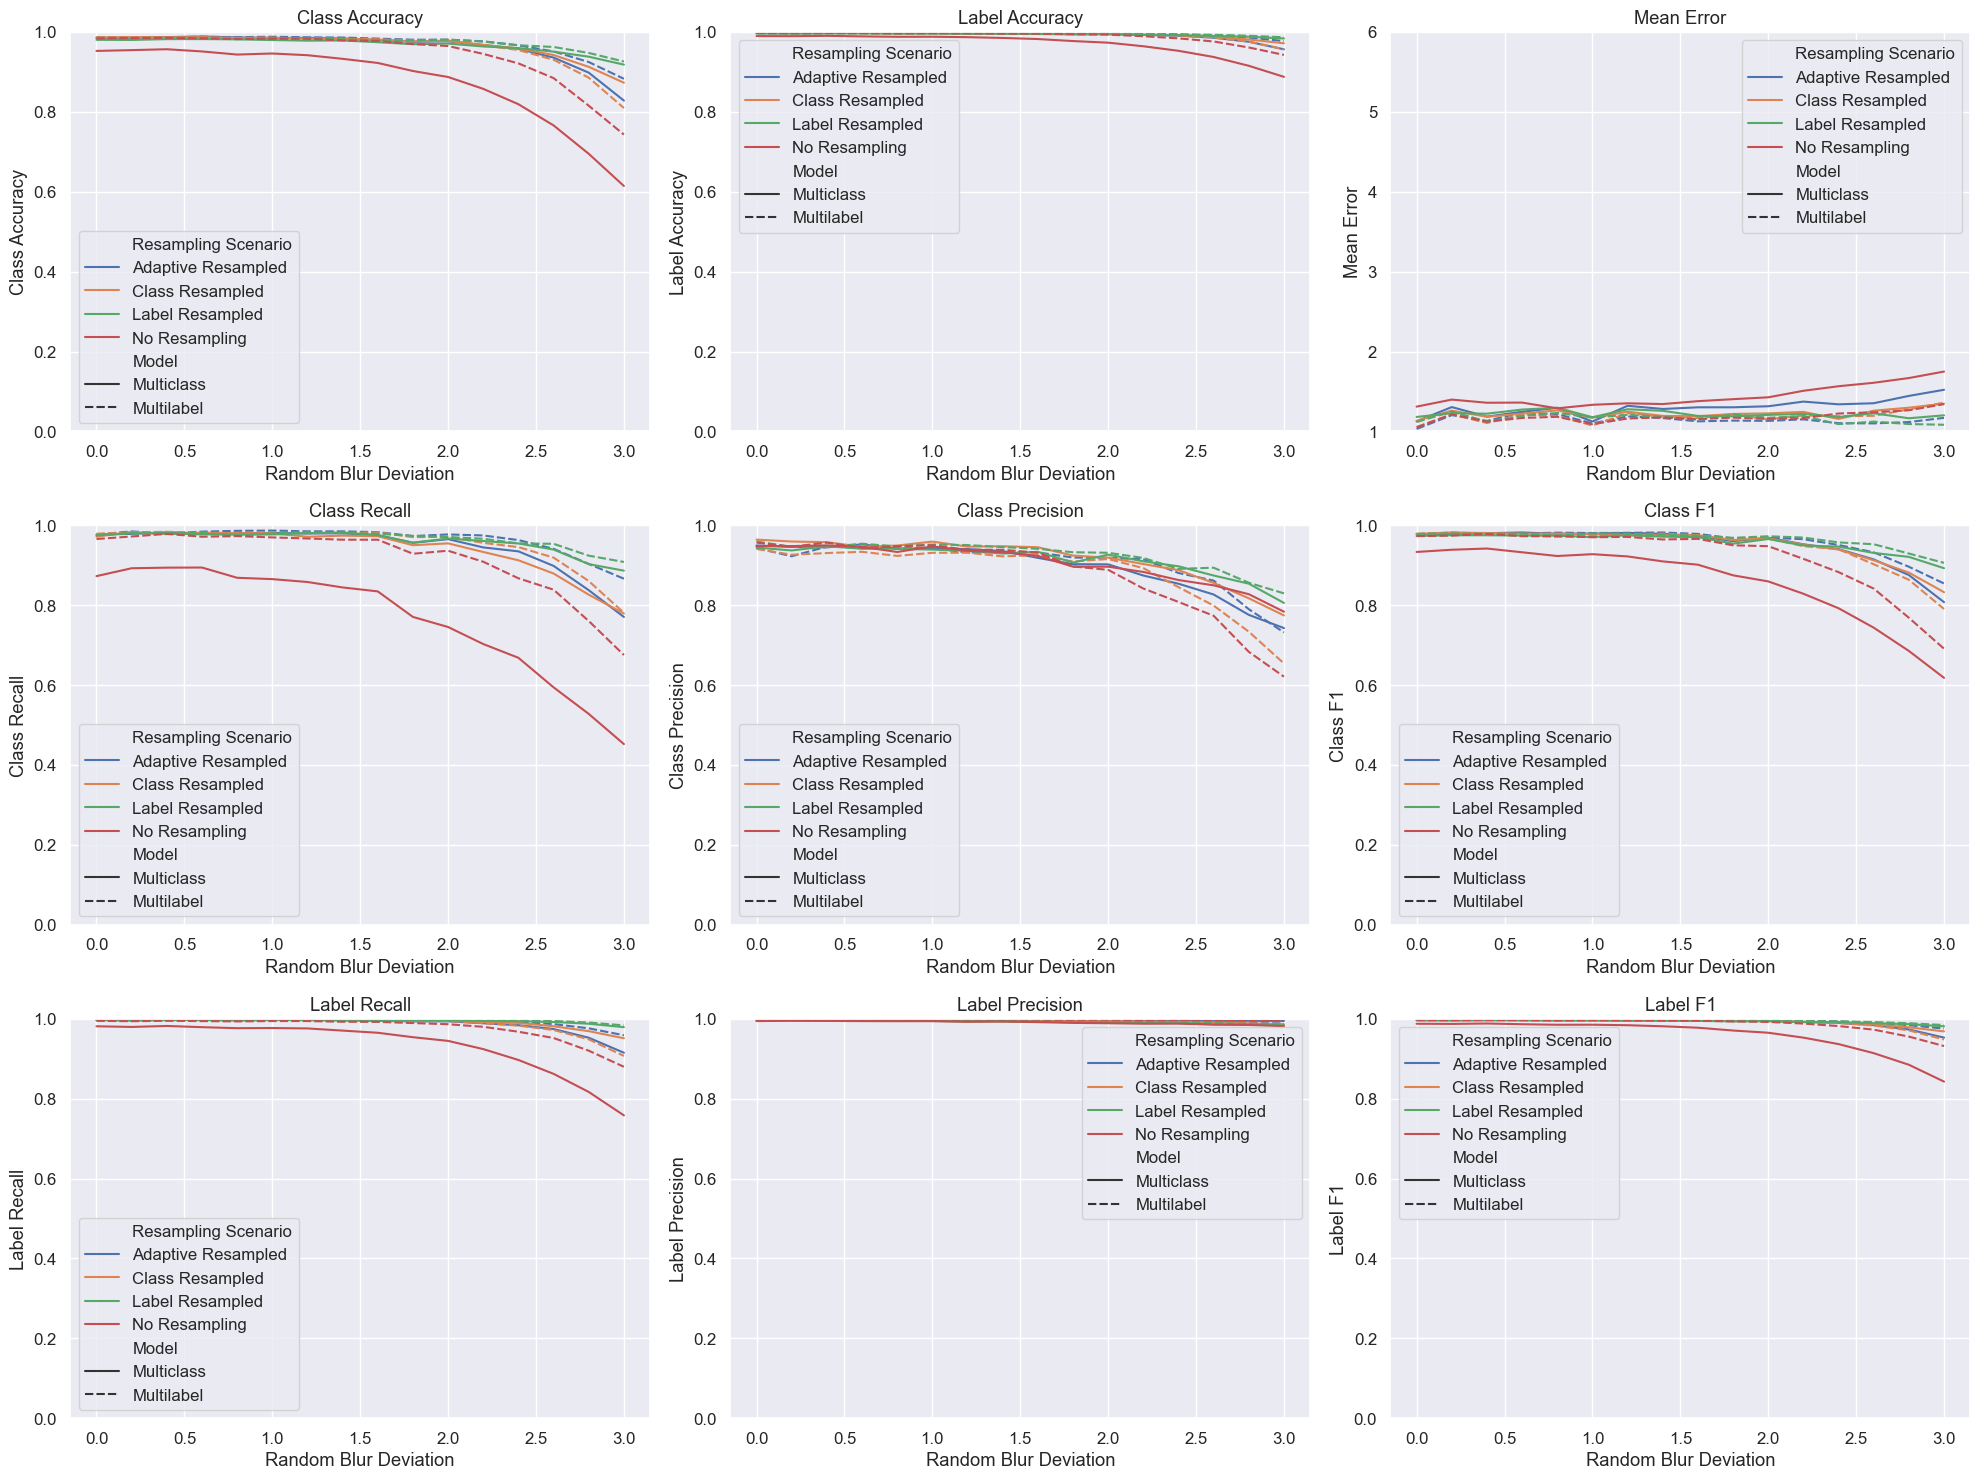

In [31]:
mean_blur_metrics = blur_metrics.drop(columns='Trial').groupby([TRAIN_COL, MODEL_COL, 'Blur']).agg('mean').reset_index()

fig, axes = plt.subplots(3, 3, figsize=(20,15))
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3] 
    sns.lineplot(data=mean_blur_metrics, x='Blur', y=metric, hue=TRAIN_COL, style=MODEL_COL, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('Random Blur Deviation')
    ax.set_ylabel(metric)
    mr = metric_ranges[metric]
    ax.set_ylim(mr[0], mr[1])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS, f'blur_{name}_{TRIALS}_trials.png'), bbox_inches='tight')

### Overall results